In [1]:
import numpy as np
import time
import os
import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard
import seaborn as sns

In [2]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

In [3]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [4]:
train_dir = os.path.join("C:\\Unik\\semestr6\\smsg_prct\\task1\\Task3\\seg_train")
validation_dir = os.path.join("C:\\Unik\\semestr6\\smsg_prct\\task1\\Task3\\seg_test")
prediction_dir = os.path.join("C:\\Unik\\semestr6\\smsg_prct\\task1\\Task3")

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=128,
                                                            image_size=IMG_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE)
pred_ds = tf.keras.utils.image_dataset_from_directory(prediction_dir,
                                                                 shuffle=True,
                                                                 batch_size=128,
                                                                 image_size=IMG_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 65888 files belonging to 6 classes.


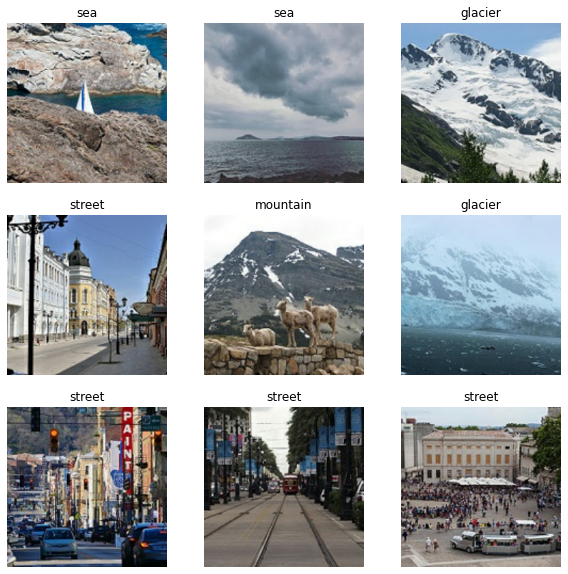

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
class_names = np.array(train_ds.class_names)
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


In [10]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
predictions = model(image_batch)

In [12]:
predictions.shape

TensorShape([128, 6])

In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) 

In [14]:
NUM_EPOCHS = 5

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/5
110/110 [==============================] - 34s 276ms/step - loss: 0.4856 - acc: 0.8261 - val_loss: 0.2678 - val_acc: 0.9033
Epoch 2/5
110/110 [==============================] - 35s 320ms/step - loss: 0.2534 - acc: 0.9105 - val_loss: 0.2382 - val_acc: 0.9140
Epoch 3/5
110/110 [==============================] - 20s 184ms/step - loss: 0.2257 - acc: 0.9208 - val_loss: 0.2261 - val_acc: 0.9170
Epoch 4/5
110/110 [==============================] - 20s 181ms/step - loss: 0.2088 - acc: 0.9267 - val_loss: 0.2195 - val_acc: 0.9180
Epoch 5/5
110/110 [==============================] - 20s 180ms/step - loss: 0.1963 - acc: 0.9304 - val_loss: 0.2155 - val_acc: 0.9183


In [15]:
loss0, accuracy0 = model.evaluate(val_ds)

94/94 [==============================] - 4s 40ms/step - loss: 0.2155 - acc: 0.9183


['street' 'glacier' 'forest' 'glacier' 'buildings' 'forest' 'mountain'
 'forest' 'mountain' 'mountain' 'forest' 'buildings' 'buildings' 'street'
 'mountain' 'glacier' 'forest' 'sea' 'forest' 'sea' 'mountain' 'glacier'
 'glacier' 'street' 'sea' 'buildings' 'forest' 'glacier' 'street'
 'mountain' 'glacier' 'mountain' 'mountain' 'glacier' 'buildings'
 'buildings' 'sea' 'glacier' 'glacier' 'sea' 'sea' 'street' 'buildings'
 'forest' 'forest' 'sea' 'street' 'glacier' 'forest' 'forest' 'mountain'
 'buildings' 'buildings' 'mountain' 'mountain' 'glacier' 'buildings' 'sea'
 'forest' 'forest' 'sea' 'street' 'forest' 'glacier' 'sea' 'sea'
 'mountain' 'street' 'street' 'sea' 'buildings' 'buildings' 'forest' 'sea'
 'forest' 'sea' 'glacier' 'mountain' 'buildings' 'glacier' 'forest' 'sea'
 'street' 'street' 'street' 'sea' 'street' 'sea' 'forest' 'forest' 'sea'
 'buildings' 'glacier' 'glacier' 'sea' 'mountain' 'street' 'glacier'
 'street' 'forest' 'buildings' 'street' 'glacier' 'forest' 'mountain'
 'mo

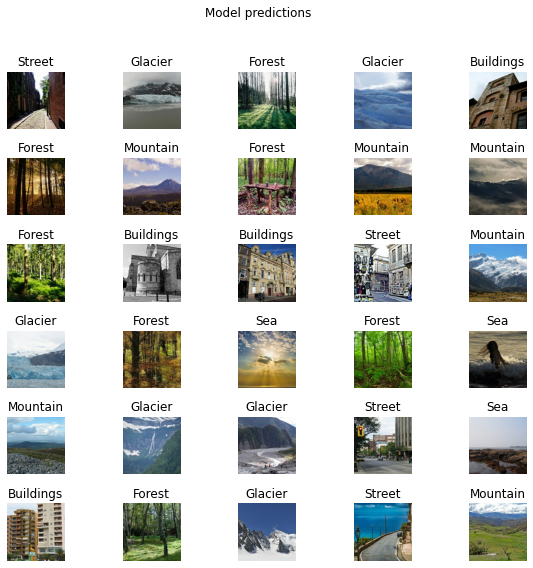

In [16]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")
